# **Test generation of random equations**
## Aim 🎯

The aim of this notebook is to generate and analyze random systems of equations using the `Equations` class from `datagen.py`. The notebook demonstrates the following:

1. **Configuration Setup**: Define the necessary parameters for generating random equations, including the number of variables, number of equations, maximum addends, and multiplicands, as well as the non-linear functions to use.
2. **Unique Naming**: Create unique names for the systems of equations based on their configuration to ensure reproducibility and avoid redundant computations.
3. **Equation Generation**: Generate the equations with the specified configuration and save them for future use.
4. **Symbolic Expression Saving**: Save the symbolic expressions of the generated equations for visualization and documentation.
5. **System Integration**: Solve the system of equations as a system of differential equations using various integration methods and compare the results.
6. **Evaluation of Non-Differential Equations**: Evaluate the system of equations as non-differential equations over a range of input values and visualize the results.

By following these steps, the notebook aims to provide a comprehensive workflow for generating, saving, and analyzing random systems of equations.

In [1]:
from src.datagen import Equations
import jax.numpy as jnp
from jax import jit, vmap, random
import cloudpickle
import hashlib
import os
import json
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scienceplots

## Define what is necessary for the generation of equations

To use the `Equations` class from `datagen.py`, you need to provide the following parameters:

### Required Parameters

1. `n_vars` (int): 
   - Number of variables in the system of equations
   - Example: `n_vars = 3` for a system with three variables

2. `n_eqs` (int):
   - Number of equations to generate
   - Example: `n_eqs = 3` to generate a system of three equations

3. `bounds_addends` (int):
   - Bounds on the number of addends in each equation
   - Example: `bounds_addends = (2, 3)` means each equation can have at least 2, and up to 3 terms added together

4. `bounds_multiplicands` (int):
   - Bounds on the number of multiplicands in each addend
   - Example: `bounds_multiplicands = (1, 2)` means each term can have at least 1, and up to 2 factors multiplied together

5. `non_lins` (tuple of functions):
   - List of all possible non-linear functions to use
   - Example: `non_lins = (jnp.sin, jnp.cos)` to use sine and cosine functions

### Optional Parameters

6. `sym_non_lins` (list of strings, optional):
   - Symbolic expressions of the non-linearities for equation visualization
   - Example: `sym_non_lins = [r"\sin", r"\cos"]` for LaTeX representation

7. `distribution` (str, optional):
   - Distribution type for generating variable indices (default: "uniform")
   - Options: "uniform", "beta", "lognormal", "custom"
   - Example: `distribution = "uniform"`

8. `a` (float, optional):
   - Parameter 'a' for beta distribution (required if `distribution` is "beta")
   - Example: `a = 2.0`

9. `b` (float, optional):
   - Parameter 'b' for beta distribution (required if `distribution` is "beta")
   - Example: `b = 5.0`

10. `sigma` (float, optional):
    - Parameter 'sigma' for lognormal distribution (required if `distribution` is "lognormal")
    - Example: `sigma = 1.0`

11. `p` (array-like, optional):
   - Probabilities for custom distribution over the variables (required if `distribution` is "custom")
   - Example: `p = [0.2, 0.5, 0.3]

12. `seed` (int, optional):
   - Seed for reproducibility (default: 42)
   - Example: `seed = 42`


Let's do an example

In [2]:
non_lins = (jnp.sin, jnp.cos)
non_lin_syms = [r"\sin", r"\cos"]

config = {
    "n_vars": 50,
    "n_eqs": 50,
    "bounds_addends": (1, 3),
    "bounds_multiplicands": (1, 2),
    "non_lins": non_lins,
    "sym_non_lins": non_lin_syms,
    "distribution": "uniform",
    "a": None,
    "b": None,
    "sigma": None,
    "p": None,
    "seed": 42
}

Here is the definition of two functions that help us creating unique names for the systems of equations based on their configuration's values

In [3]:
def filter_config(config):
    """Filter and convert the configuration into a deterministic, serializable format."""
    filtered_config = {}
    for key, value in config.items():
        if isinstance(value, tuple):  # Convert tuples of functions to names
            filtered_config[key] = tuple(v.__name__ if callable(v) else v for v in value)
        elif callable(value):  # Replace single functions with their name
            filtered_config[key] = value.__name__
        elif isinstance(value, dict):  # Recursively process nested dictionaries
            filtered_config[key] = filter_config(value)
        else:
            filtered_config[key] = value
    return filtered_config

def get_unique_name_from_config(config):
    # Filter out non-deterministic or non-serializable elements
    filtered_config = filter_config(config)
    
    # Convert the filtered dictionary to a JSON string with sorted keys
    config_string = json.dumps(filtered_config, sort_keys=True)
    
    # Generate a hash from the string representation
    config_hash = hashlib.md5(config_string.encode()).hexdigest()
    
    # Use the hash to create a unique filename
    filename = f"equations_{config_hash}"
    return filename

Here we can see a brief example of what happens when we ask for a filename

In [4]:
first_filename = get_unique_name_from_config(config)
print(first_filename)

equations_c977aea8db28e362643faae317c243e0


If we change the configuration, for example by setting a different non linearity, the name will be different

In [5]:
non_lins = (jnp.tan, jnp.cos)


config = {
    "n_vars": 50,
    "n_eqs": 50,
    "bounds_addends": (1, 3),
    "bounds_multiplicands": (1, 2),
    "non_lins": non_lins,
    "sym_non_lins": non_lin_syms,
    "distribution": "uniform",
    "a": None,
    "b": None,
    "sigma": None,
    "p": None,
    "seed": 42
}

second_filename = get_unique_name_from_config(config)
print(first_filename, second_filename)

equations_c977aea8db28e362643faae317c243e0 equations_eea3367e585ce3754d51fc5943f8edbf


And going back to the original configuration we go back to the previous name

In [6]:
non_lins = (jnp.sin, jnp.cos)

config = {
    "n_vars": 50,
    "n_eqs": 50,
    "bounds_addends": (1, 3),
    "bounds_multiplicands": (1, 2),
    "non_lins": non_lins,
    "sym_non_lins": non_lin_syms,
    "distribution": "uniform",
    "a": None,
    "b": None,
    "sigma": None,
    "p": None,
    "seed": 42
}

third_filename = get_unique_name_from_config(config)
print(first_filename, third_filename)

equations_c977aea8db28e362643faae317c243e0 equations_c977aea8db28e362643faae317c243e0


This is done because if we end up setting the same configuration of an existing system, we can autmatically check if it already exists, and then reading it instead of generating it, thus saving us time

## Generating and Loading the System of Equations

To generate the equations with the specified configuration we just need to write this simple command `Equations(**config)`. 

However, before creating a new system, the code first checks if a pre-existing system file is stored in the `Data` directory. If the file exists, it loads the saved system using `cloudpickle`, avoiding redundant computations.

If the system file does not exist, a new instance of `Equations` is created using the given configuration, and the object is serialized and saved as a `.pkl` file for future use.

This ensures that the system is only generated once, improving efficiency by reusing previously stored results.

In [7]:
save_dir = "Data"

if os.path.exists(os.path.join(save_dir, first_filename+'.pkl')):
    print("System already exists")
    with open(os.path.join(save_dir, first_filename+'.pkl'), 'rb') as f:
        system = cloudpickle.load(f)
else:
    # Save the system variable to a file
    with open(os.path.join(save_dir, first_filename+'.pkl'), 'wb') as f:
        system = Equations(**config)
        cloudpickle.dump(system, f)
    print(f"System saved as {first_filename}.pkl in directory {save_dir}")

System already exists


## Using the save_symb_expr Function

The `save_symb_expr` function is used to save the symbolic expressions of the equations in the system. To use this function, you need to provide the following parameters:

### Required Parameters

1. `filename` (str): 
   - The name of the file where the symbolic expressions will be saved
   - Example: `filename = "equations_symbolic.pdf"`

### Optional Parameters

2. `max_eq_per_page` (int, optional):
   - The maximum number of equations in each page of the PDF (default: 35)
   - Example: `max_eq_per_page = 30`

In [8]:
system.save_symb_expr(filename=os.path.join(save_dir, first_filename+'_symbolic.pdf'))

PDF already exists


## Evaluate the system

In the case the system is viewed as a system of differential equations, it is obviously possible to solve the system using the integrator that you prefer by passing the system to function, we can use for example the function `solve_ivp` from scipy

In [9]:
time_interval = [0, 1]
t_eval = jnp.linspace(time_interval[0], time_interval[1], int(1e5)) 
key = random.key(config['seed'])
initial_conditions = random.uniform(key, shape=(config['n_eqs'],))
integration_method = 'BDF'

sol = solve_ivp(system, time_interval, initial_conditions, integration_method, t_eval=t_eval)
print(sol.y)

[[0.99080086 0.990807   0.99081315 ... 1.57609911 1.57610021 1.57610131]
 [0.47302067 0.47302478 0.47302889 ... 0.7526923  0.7526918  0.75269129]
 [0.35674226 0.35675745 0.35677264 ... 2.27932377 2.27934743 2.27937109]
 ...
 [0.29565513 0.29567078 0.29568642 ... 1.49925544 1.49926496 1.49927447]
 [0.97342014 0.97343089 0.97344163 ... 1.71882249 1.71882301 1.71882352]
 [0.38643587 0.38644192 0.38644798 ... 1.05490509 1.05490748 1.05490986]]


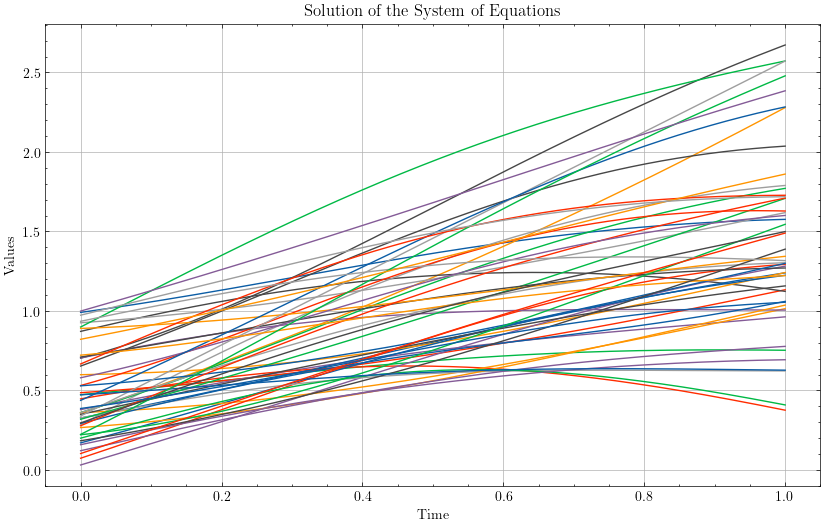

In [10]:
plt.style.use('science')

time_points = sol.t
solution = sol.y

plt.figure(figsize=(10, 6))
for i in range(solution.shape[0]):
    plt.plot(time_points, solution[i], label=f'Variable {i+1}')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Solution of the System of Equations')
plt.grid(True)
plt.show()

I now try different integrators to see if they give different solutions, just a sanity check for my handmade class.

In [11]:
sol_BDF = solve_ivp(system, time_interval, initial_conditions, 'BDF')
sol_RK45 = solve_ivp(system, time_interval, initial_conditions, 'RK45')
sol_RK23 = solve_ivp(system, time_interval, initial_conditions, 'RK23')
sol_Radau = solve_ivp(system, time_interval, initial_conditions, 'Radau')

In [12]:
last_values_BDF = sol_BDF.y[:, -1]
last_values_RK45 = sol_RK45.y[:, -1]
last_values_RK23 = sol_RK23.y[:, -1]
last_values_Radau = sol_Radau.y[:, -1]

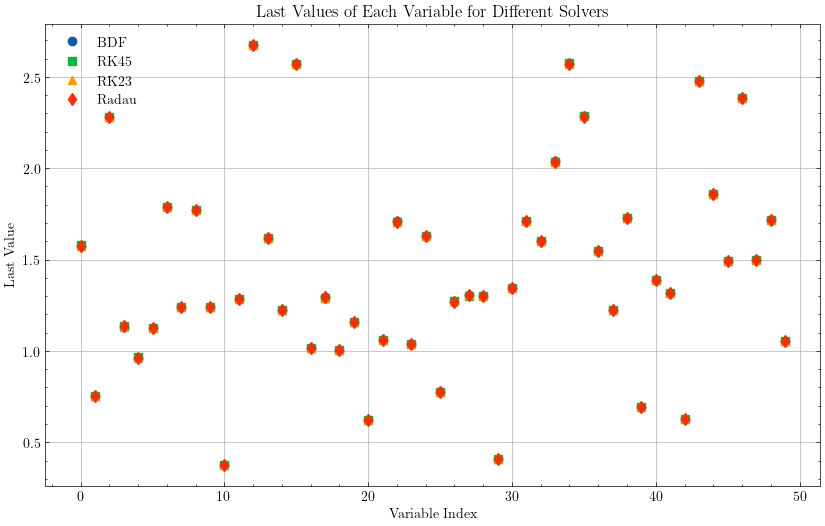

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(last_values_BDF, 'o', label='BDF')
plt.plot(last_values_RK45, 's', label='RK45')
plt.plot(last_values_RK23, '^', label='RK23')
plt.plot(last_values_Radau, 'd', label='Radau')
plt.xlabel('Variable Index')
plt.ylabel('Last Value')
plt.title('Last Values of Each Variable for Different Solvers')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
last_values_stack = jnp.stack([last_values_BDF, last_values_RK45, last_values_RK23, last_values_Radau])
std_devs = jnp.std(last_values_stack, axis=0)
print(std_devs)

[6.4351619e-04 6.7463698e-04 9.6108986e-04 7.0602377e-04 3.9769482e-04
 6.7933637e-05 4.0067334e-04 1.1296769e-04 4.3681715e-04 3.0098794e-04
 2.9356271e-04 1.4798145e-04 5.3819391e-04 7.7827525e-04 1.7700746e-04
 6.2667031e-04 1.3547137e-04 4.4990104e-04 2.1379103e-04 1.4566908e-04
 3.2342327e-04 4.8139627e-04 3.9178712e-04 4.3313511e-04 3.7250505e-04
 1.0717829e-04 1.6849443e-04 2.5361756e-04 4.3313511e-04 8.2407269e-04
 8.3081785e-04 5.5562617e-04 2.4219407e-04 3.9434797e-04 4.9562269e-04
 5.0176034e-04 2.5975978e-04 4.3407528e-04 4.0552928e-04 2.5628851e-04
 2.2720260e-04 3.5191997e-04 3.4548910e-04 2.4806094e-04 3.1218119e-04
 3.1808403e-04 1.0105552e-04 2.1051384e-04 1.6391129e-04 3.3676904e-04]


## Equations of the system viewed as non differential equations

In this section, we evaluate the system of equations as non-differential equations using the `evaluate` function. We define a JIT-compiled `evaluate` function that takes input data and returns the corresponding results. We generate a range of input values for each variable, vectorize the evaluation using `vmap`, and plot the results to visualize the behavior of the equations.

In [15]:
@jit
def evaluate(values):
    return system(y=values)

In [29]:
values = jnp.tile(jnp.linspace(0, 10, 1000).reshape(-1, 1), (1, config['n_eqs']))

evaluated_values = []
evaluated_values = vmap(evaluate)(values)

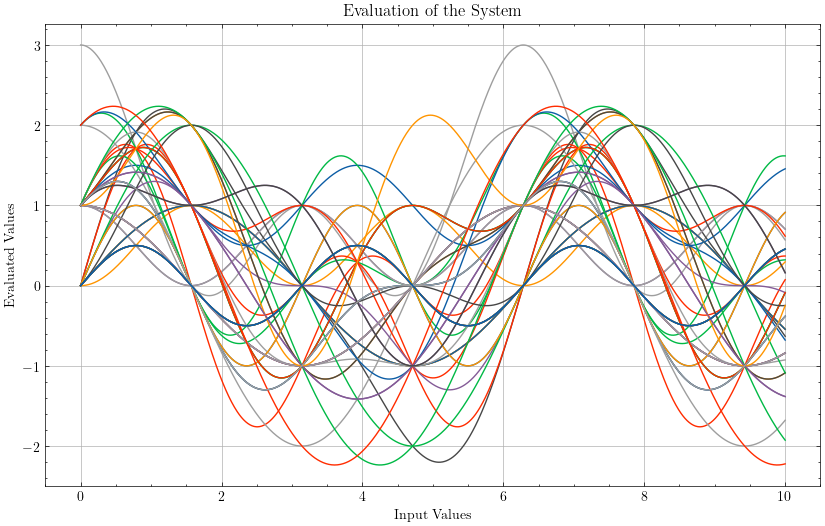

In [31]:
plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.plot(values[:, 0], evaluated_values[:, i])
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System')
plt.grid(True)
plt.show()

## Using the `show_graph` Method

The `show_graph` method is used to visualize the structure of the generated system of equations. This method creates a graphical representation of the equations in a hierarchical manner, showing the relationships between variables and functions.

### Usage

To use the `show_graph` method, simply call it on an instance of the `Equations` class. For example:

```python
system.show_graph()
```

This will generate and display the graph of the system of equations. The smaller circle consists of all the variables, while the middle circle consists of functions that depend on the variables but do not contain other functions. The outer layer consists of functions that depend on other functions.

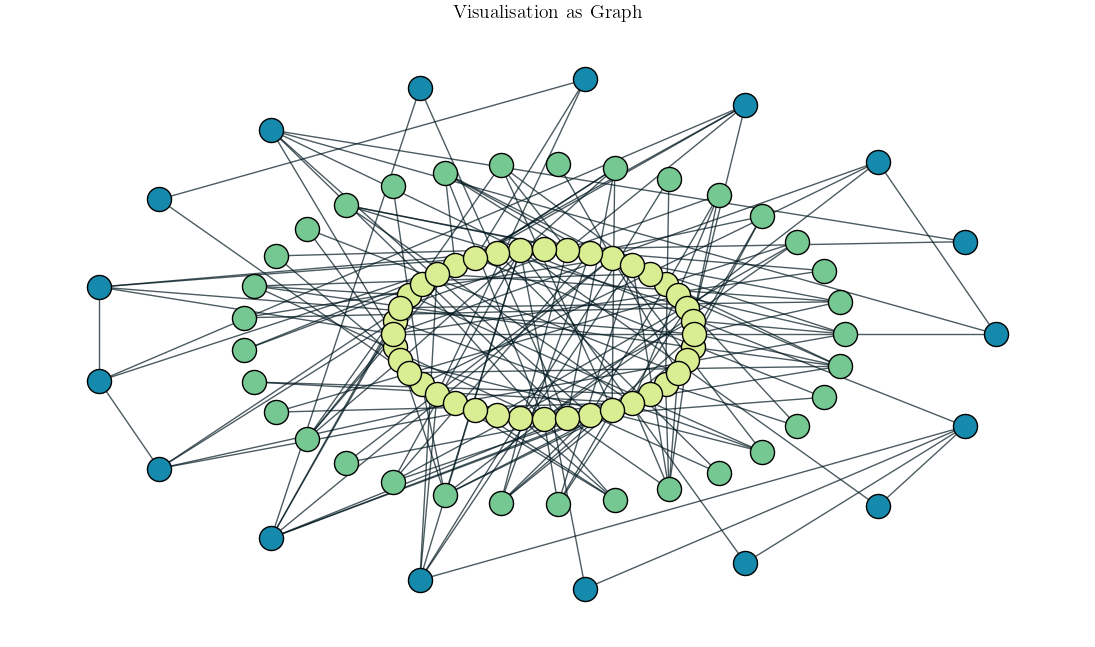

<Figure size 350x262.5 with 0 Axes>

In [32]:
system.show_graph()